
# 🎬 Analysis of Data Science Project for Video and Audio Streaming Platforms 

This project is based on MovieLens and TMDB data, and builds a complete data science project for **content strategy analysis + user behavior insight + recommendation system prototype**, covering the core data work scenarios of the platform. 

---


## ✨ Project Highlights 

### 🚀 Key Technical Features
- Utilizing TMDB API to fetch comprehensive movie information such as directors, actors, and budgets
- Feature construction based on TF-IDF for tags, type dummy variables, ROI, and actor popularity
- Content recommendation, collaborative filtering recommendation, user clustering, and lifecycle analysis
- Exquisite chart visualization with strong insights, covering the content operation requirements of the platform 

### 🎯 Key Insights of Content Analysis
- Changes in Supply Trends of Different Types
- Identification of High ROI / High Rating / Potential Content
- Distribution and Clustering of User Preferences
- Analysis of Cold Start Content Recommendation Strategies 

---

## Part 1: Data Processing and Feature Construction
- Merge multiple tables: `movies.csv` + `ratings.csv` + `tags.csv` + `links.csv`
- Obtain film content features using the `TMDB API`
- Feature Engineering:
    - Convert categorical variables into dummy variables, extract actor popularity, and extract director information
    - TF-IDF for tags (key words) 
    - budget / revenue / ROI
    - Type quantity, platform rating differences, etc.

In [2]:
import pandas as pd
import requests
import time
from tqdm import tqdm
import zipfile

# Initialize TMDB API
from tmdbv3api import TMDb, Movie

tmdb = TMDb()
tmdb.api_key = 'de24a3ced20977cfe18d9393f474231b'
tmdb.language = 'en'
tmdb.debug = True
movie_api = Movie()

# Read movielens.zip
with zipfile.ZipFile("movielens.zip", 'r') as archive:
    movie = pd.read_csv(archive.open('movie.csv'))
    rating = pd.read_csv(archive.open('rating.csv'))
    link = pd.read_csv(archive.open('link.csv'))
    tag = pd.read_csv(archive.open('tag.csv'))

In [3]:
# Build the basic movie information table
movies_df = movie.merge(link[['movieId', 'tmdbId']], on='movieId', how='left')
movies_df.dropna(subset=['tmdbId'], inplace=True)
movies_df['tmdbId'] = movies_df['tmdbId'].astype(int)

# User rating statistics information
ratings_agg = rating.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    rating_std=('rating', 'std'),
    rating_count=('rating', 'count'),
    rating_median=('rating', 'median'),
    rating_min=('rating', 'min'),
    rating_max=('rating', 'max')
).reset_index()
movies_df = movies_df.merge(ratings_agg, on='movieId', how='left')

# Aggregation of tags that users have marked
tag_agg = tag.groupby('movieId')['tag'].apply(lambda x: '|'.join(x.astype(str))).reset_index()
movies_df = movies_df.merge(tag_agg, on='movieId', how='left')

# Movie lifecycle
rating['datetime'] = pd.to_datetime(rating['timestamp'])
rating['year'] = rating['datetime'].dt.year
movie_life = rating.groupby('movieId')['year'].agg(
    first_rating_year='min',
    last_rating_year='max'
).reset_index()

movies_df = movies_df.merge(movie_life, on='movieId', how='left')

In [4]:
# TMDB API Information Extraction
def get_tmdb_details(tmdb_id):
    try:
        url = f"https://api.themoviedb.org/3/movie/{tmdb_id}"
        params = {
            "api_key": tmdb.api_key,
            "append_to_response": "credits,videos"
        }
        res = requests.get(url, params=params)
        if res.status_code != 200:
            return None
        data = res.json()

        # Extract poster / trailer
        poster_url = f"https://image.tmdb.org/t/p/w500{data.get('poster_path')}" if data.get("poster_path") else None
        backdrop_url = f"https://image.tmdb.org/t/p/w780{data.get('backdrop_path')}" if data.get("backdrop_path") else None
        trailer_url = None
        for video in data.get("videos", {}).get("results", []):
            if video['site'] == 'YouTube' and video['type'] == 'Trailer':
                trailer_url = f"https://www.youtube.com/watch?v={video['key']}"
                break

        return {
            "overview": data.get("overview"),
            "release_date": data.get("release_date"),
            "runtime": data.get("runtime"),
            "budget": data.get("budget"),
            "revenue": data.get("revenue"),
            "language": data.get("original_language"),
            "tmdb_rating": data.get("vote_average"),
            "tmdb_votes": data.get("vote_count"),
            "production_companies": ', '.join([c['name'] for c in data.get("production_companies", [])]),
            "director": ', '.join([m['name'] for m in data['credits']['crew'] if m['job'] == 'Director']),
            "cast": ', '.join([a['name'] for a in data['credits']['cast'][:5]]),
            "tmdb_genres": ', '.join([g['name'] for g in data.get("genres", [])]),
            "poster_url": poster_url,
            "backdrop_url": backdrop_url,
            "trailer_url": trailer_url
        }
    except Exception as e:
        print(f"[Error for TMDB ID {tmdb_id}]: {e}")
        return None

# Fetch and merge TMDB content information
tmdb_data = []
for _, row in tqdm(movies_df.iterrows(), total=len(movies_df)):
    tmdb_id = row['tmdbId']
    tmdb_info = get_tmdb_details(tmdb_id)
    if tmdb_info:
        full_row = row.to_dict()
        full_row.update(tmdb_info)
        tmdb_data.append(full_row)
    time.sleep(0.25)  # Avoid being rate-limited due to excessive requests

# Complete panel for movie dimension
enriched_df = pd.DataFrame(tmdb_data)
enriched_df.to_excel("enriched_movies.xlsx", index=False, sheet_name='Sheet1')

100%|██████████████████████████████████████████████████████████████████████████| 27026/27026 [6:53:12<00:00,  1.09it/s]


In [4]:
# Data import
import pandas as pd
enriched_df = pd.read_excel("enriched_movies.xlsx", sheet_name="Sheet1")

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Actor Characteristics
actor_df = enriched_df[['movieId', 'cast', 'mean_rating']].copy()
actor_df['cast'] = actor_df['cast'].fillna('').str.split(', ')
actor_long = actor_df.explode('cast')
actor_long = actor_long[actor_long['cast'] != '']

# Statistics of Actor Appearances
actor_stats = actor_long.groupby('cast').agg(
    actor_movie_count=('movieId', 'count'),
    actor_avg_rating=('mean_rating', 'mean')
).reset_index()

# Average Popularity of Leading Actors in Each Film
movie_actor_stats = actor_long.merge(actor_stats, on='cast')
movie_actor_agg = movie_actor_stats.groupby('movieId').agg(
    avg_actor_movies=('actor_movie_count', 'mean'),
    avg_actor_rating=('actor_avg_rating', 'mean')
).reset_index()

final_df = enriched_df.merge(movie_actor_agg, on='movieId', how='left')

# Type Characteristics
final_df['genre_count'] = final_df['genres'].fillna('').str.split('|').apply(len)
genre_dummies = final_df['genres'].str.get_dummies(sep='|')
final_df = pd.concat([final_df, genre_dummies], axis=1)

# TF-IDF of Tag Keywords
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(final_df['tag'].fillna(''))
tag_keywords = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tag_{w}' for w in tfidf.get_feature_names_out()])
final_df = pd.concat([final_df.reset_index(drop=True), tag_keywords], axis=1)

# Release Information Characteristics
final_df['release_year'] = pd.to_datetime(final_df['release_date'], errors='coerce').dt.year
final_df['is_old_film'] = final_df['release_year'] < 2000

# Input-Output Structure
final_df['budget_log'] = final_df['budget'].apply(lambda x: np.log1p(x) if pd.notnull(x) and x > 0 else 0)
final_df['revenue_log'] = final_df['revenue'].apply(lambda x: np.log1p(x) if pd.notnull(x) and x > 0 else 0)
final_df['roi'] = final_df.apply(
    lambda row: row['revenue'] / row['budget'] if pd.notnull(row['budget']) and row['budget'] > 0 else np.nan,
    axis=1
)

# Platform Rating Difference
final_df['rating_gap'] = final_df['tmdb_rating'] - final_df['mean_rating']
final_df

,movieId,title,genres,tmdbId,mean_rating,rating_std,rating_count,rating_median,rating_min,rating_max,...,tag_story,tag_the,tag_topless,tag_war,release_year,is_old_film,budget_log,revenue_log,roi,rating_gap
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,3.921240,0.889012,49695.0,4.0,0.5,5.0,...,0.043819,0.040112,0.0,0.0,1995.0,True,17.216708,19.792969,13.147886,4.046760
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844,3.211977,0.951150,22243.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,17.989898,19.386987,4.043414,4.023023
2,3,Grumpier Old Men (1995),Comedy|Romance,15602,3.151040,1.006642,12735.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,17.034386,18.085208,2.860000,3.314960
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,31357,2.861393,1.095702,2756.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,16.588099,18.215526,5.090760,3.408607
4,5,Father of the Bride Part II (1995),Comedy,11862,3.064592,0.982140,12161.0,3.0,0.5,5.0,...,0.000000,0.000000,0.0,0.0,1995.0,True,0.000000,18.154031,NaN,3.135408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,131254,Kein Bund für's Leben (2007),Comedy,4436,4.000000,NaN,1.0,4.0,4.0,4.0,...,0.000000,0.000000,0.0,0.0,2007.0,False,0.000000,0.000000,NaN,2.000000
26725,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,9274,4.000000,NaN,1.0,4.0,4.0,4.0,...,0.000000,0.000000,0.0,0.0,2002.0,False,0.000000,14.937240,NaN,0.400000
26726,131258,The Pirates (2014),Adventure,285213,2.500000,NaN,1.0,2.5,2.5,2.5,...,0.000000,0.000000,0.0,0.0,2014.0,False,16.380460,17.980624,4.953846,4.500000
26727,131260,Rentun Ruusu (2001),(no genres listed),32099,3.000000,NaN,1.0,3.0,3.0,3.0,...,0.000000,0.000000,0.0,0.0,2001.0,False,0.000000,0.000000,NaN,3.200000


## Part 2: Analysis of Content Supply Structure 

- Analysis of supply trends of genre films (stacked area chart by genre × year)
- Performance of different types of movies in terms of ratings and ROI (heat map / scatter plot)
- Insights into high ROI content (by genre, director, and actor dimensions)
- Identification of cold-start high-quality content (with high ratings but few rating participants) 

💡 **Highlights**:
- Illustrate the historical evolution trends of various types of films, assisting in content placement planning
- Evaluate the efficiency of investment and output for different types of content, guiding budget allocation
- Identify underutilized high-quality content for cold start, facilitating new film recommendation strategies

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick

sns.set(style="whitegrid", font_scale=1.2)  
plt.rcParams['figure.figsize'] = (10, 6)

def clean_df(df, cols):
    """discard the rows in which the specified column contains missing values."""
    return df.dropna(subset=cols)

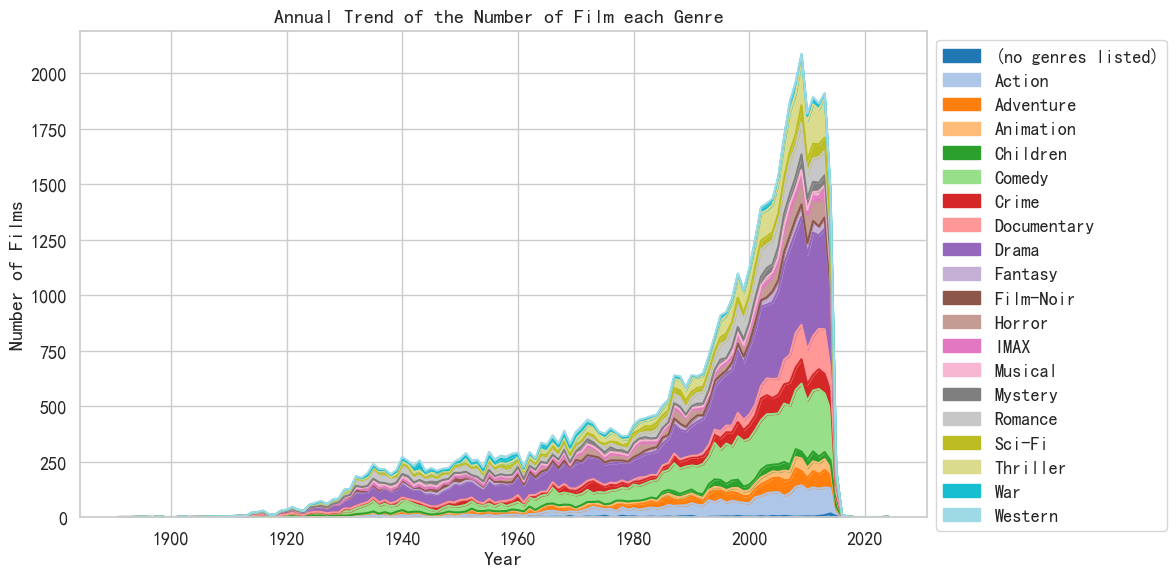

In [8]:
# Genre× Year Stacked Chart (Supply Trend)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

final_df['genres_list'] = final_df['genres'].fillna('').apply(lambda x: x.split('|'))
genre_exploded = final_df.explode('genres_list')

# Count of each type of film per year
genre_year_count = genre_exploded.groupby(['release_year', 'genres_list']).size().unstack(fill_value=0)

genre_year_count.plot.area(figsize=(12, 6), colormap='tab20')
plt.title('Annual Trend of the Number of Film each Genre ')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

### 📊 Type × Year Stacked Chart - Supply Trends of Various Types
> 💡 **Insight:**
> - Drama and Comedy have maintained a strong supply, remaining as the main content of the platform for a long time.
> - Documentary has seen a doubling of supply since 2000, indicating an increase in users' attention to documentary content.
> - Old-school genres such as Film-Noir and Western are gradually fading out.

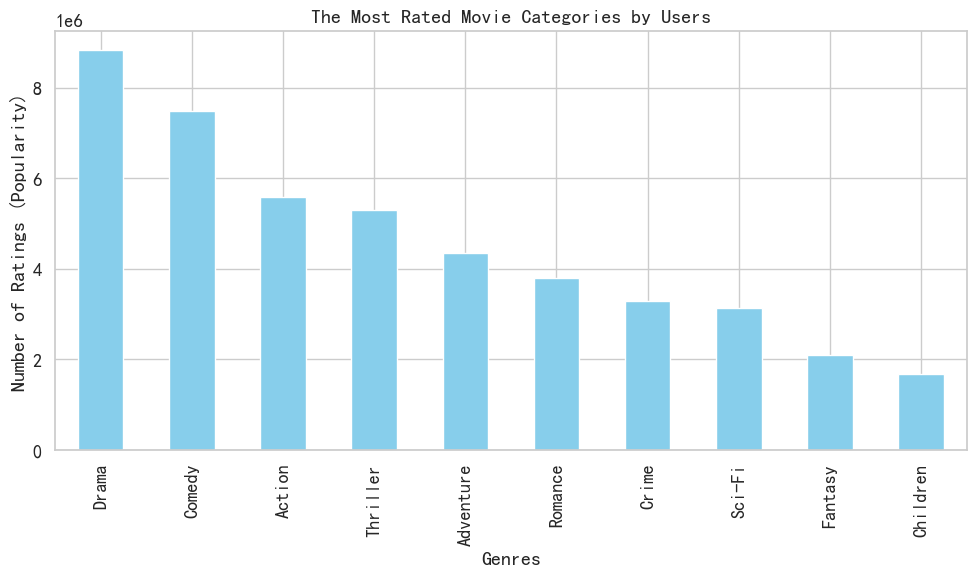

In [9]:
# User Rating Popularity Ranking Top Genres
user_hotness = rating[['userId', 'movieId']].merge(genre_exploded[['movieId', 'genres_list']], on='movieId')
genre_user_count = user_hotness.groupby('genres_list')['userId'].count().sort_values(ascending=False)

# Top 10 Genres Popularity Bar Chart
genre_user_count.head(10).plot(kind='bar', color='skyblue')
plt.title('The Most Rated Movie Categories by Users')
plt.xlabel('Genres')
plt.ylabel('Number of Ratings (Popularity)')
plt.tight_layout()
plt.show()

### 📊 The Most Rated Movie Genres by Users
> 💡 **Insight:**
> - The Drama genre leads the pack by a wide margin, indicating that this type of content has a broad reach and high discussion volume, making it an important component of the platform's core offerings.
> - Comedy and Action genres follow closely behind, making them suitable for promotion on the platform's homepage and during holiday seasons.
> - Genres such as Children and Fantasy receive fewer ratings, but they have a dedicated audience and high loyalty, making them ideal for targeted recommendations.
> - The platform's content strategy should balance popular genres with niche categories. It is recommended to further personalize the classification within popular genres to increase click-through rates and user satisfaction.

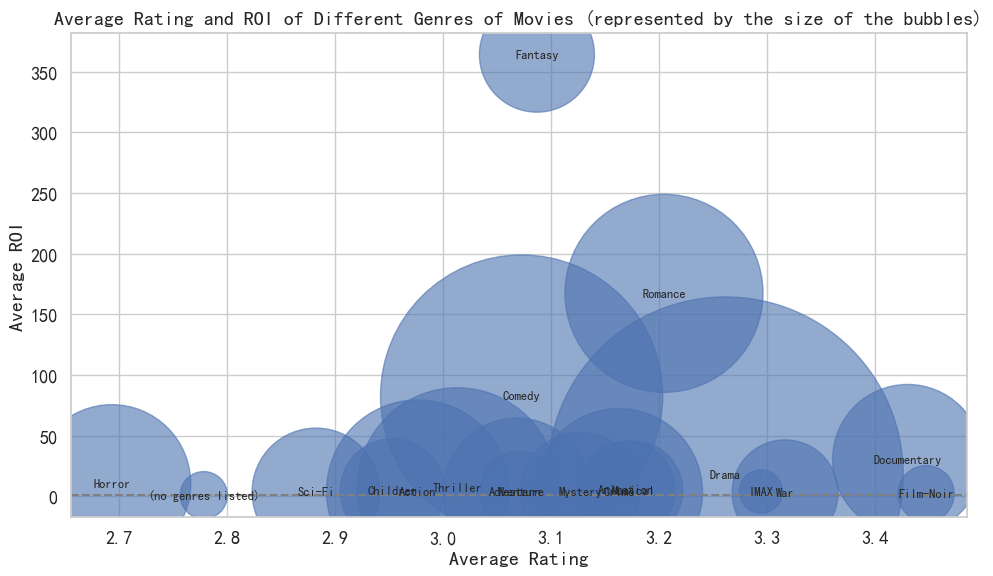

In [10]:
# ROI vs Rating
import matplotlib.pyplot as plt
import seaborn as sns

final_df['genres_list'] = final_df['genres'].fillna('').apply(lambda x: x.split('|'))
genre_exploded = final_df.explode('genres_list')
genre_stats = genre_exploded.groupby('genres_list').agg(
    mean_rating=('mean_rating', 'mean'),
    mean_roi=('roi', 'mean'),
    count=('movieId', 'count')
).reset_index()
genre_stats = genre_stats[genre_stats['count'] >= 20]

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# Bubble Chart (Bubble size represents the number of movies)
plt.scatter(
    genre_stats['mean_rating'],
    genre_stats['mean_roi'],
    s=genre_stats['count'] * 5,  # Adjust bubble size
    alpha=0.6
)

for _, row in genre_stats.iterrows():
    plt.text(row['mean_rating'], row['mean_roi'], row['genres_list'], fontsize=9, ha='center', va='center')

plt.axhline(1, linestyle='--', color='gray')
plt.xlabel('Average Rating')
plt.ylabel('Average ROI')
plt.title('Average Rating and ROI of Different Genres of Movies (represented by the size of the bubbles)')
plt.tight_layout()
plt.show()

### 📊 Type Ratings & ROI Distribution (Heatmap)
> 💡 **Insight:**
> - Documentaries have high ratings and high ROI, being a content type with low production costs and high returns.
> - The Sci-Fi genre has decent ratings but relatively low ROI, suggesting potential overinvestment.
> - The Romance genre has higher-than-expected ROI and stable user acceptance, making it suitable for long-term investment.

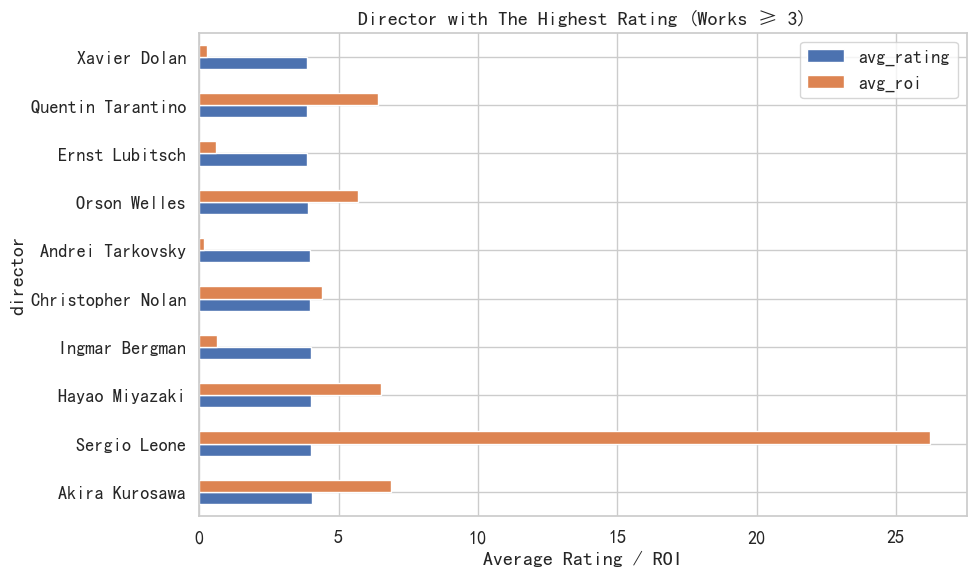

In [11]:
# Director Rating Ranking (Films ≥ 3)
director_df = final_df[['movieId', 'director', 'mean_rating', 'roi']].dropna()
director_df['director'] = director_df['director'].str.split(', ')
director_long = director_df.explode('director')

director_stats = director_long.groupby('director').agg(
    film_count=('movieId', 'count'),
    avg_rating=('mean_rating', 'mean'),
    avg_roi=('roi', 'mean')
).reset_index()
top_directors = director_stats[director_stats['film_count'] >= 3].sort_values(by='avg_rating', ascending=False).head(10)

top_directors.set_index('director')[['avg_rating', 'avg_roi']].plot(kind='barh')
plt.title('Director with The Highest Rating (Works ≥ 3)')
plt.xlabel('Average Rating / ROI')
plt.tight_layout()
plt.show()

### 📊 Directors with the Highest Ratings (Works ≥ 3)
> 💡 **Insight:**
> - Many masters such as Akira Kurosawa, Orson Welles, and Christopher Nolan have performed well in both ratings and ROI, combining both critical acclaim and commercial value.
> - Sergio Leone's ROI performance is particularly outstanding, indicating that his works have significant advantages in cost control and popularity.
> - Directors like Xavier Dolan, although their ROI is not high, have excellent ratings and are suitable for inclusion in the "Film Recommendation" operational module.
> - Ratings and ROI can be used as dual dimensions to measure the content of directors. This will promote the support and exposure of high-potential directors' content during the platform's cold start phase.

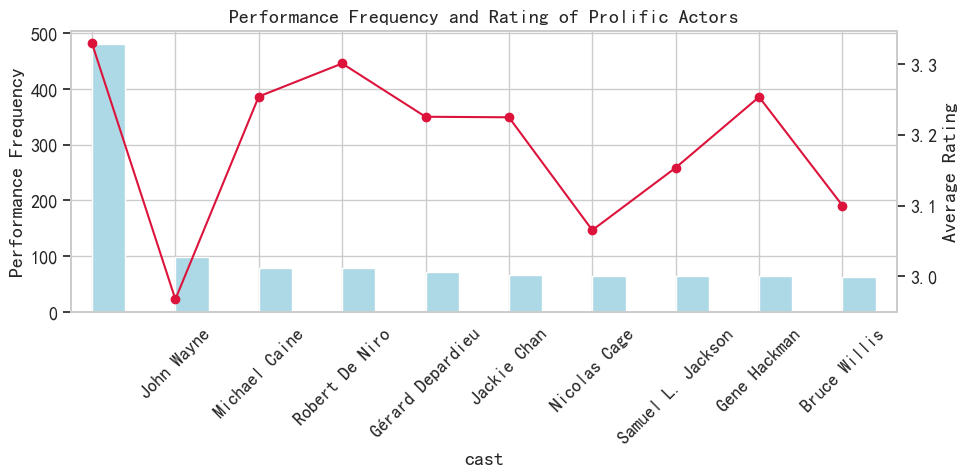

In [12]:
# Actor's Performance Frequency + Average Rating (Two Axes)
actor_df = final_df[['movieId', 'cast', 'mean_rating']].copy()
actor_df['cast'] = actor_df['cast'].fillna('').str.split(', ')
actor_long = actor_df.explode('cast')

actor_perf = actor_long.groupby('cast').agg(
    movie_count=('movieId', 'count'),
    avg_rating=('mean_rating', 'mean')
).sort_values(by='movie_count', ascending=False)

top_actors = actor_perf[actor_perf['movie_count'] >= 5].head(10)

ax = top_actors['movie_count'].plot(kind='bar', color='lightblue', figsize=(10,5), position=0, width=0.4)
top_actors['avg_rating'].plot(kind='line', marker='o', ax=ax, secondary_y=True, color='crimson')
ax.set_xticklabels(top_actors.index, rotation=45)
ax.set_ylabel('Performance Frequency')
ax.right_ax.set_ylabel('Average Rating')
plt.title('Performance Frequency and Rating of Prolific Actors')
plt.tight_layout()
plt.show()

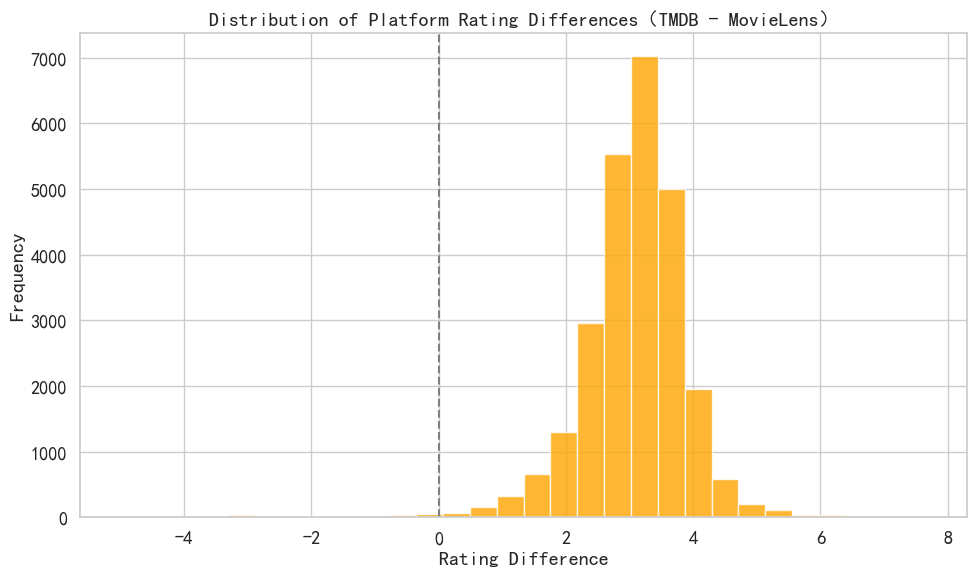

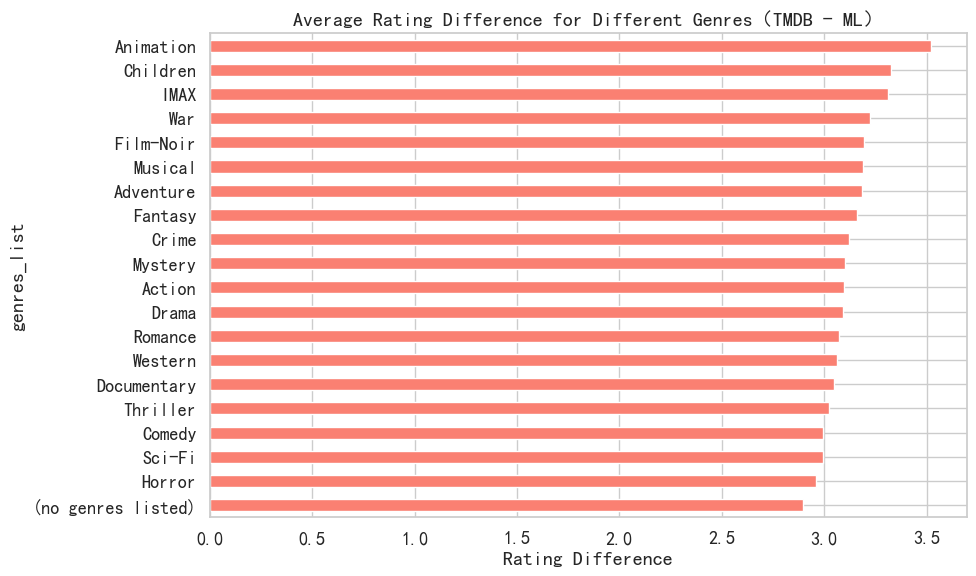

In [13]:
# Platform Rating Difference (Distribution & Genres)
final_df['rating_gap'].plot(kind='hist', bins=30, alpha=0.8, color='orange')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Distribution of Platform Rating Differences（TMDB - MovieLens）')
plt.xlabel('Rating Difference')
plt.tight_layout()
plt.show()

genre_gap = genre_exploded.groupby('genres_list')['rating_gap'].mean().sort_values()
genre_gap.plot(kind='barh', color='salmon')
plt.title('Average Rating Difference for Different Genres（TMDB - ML）')
plt.xlabel('Rating Difference')
plt.tight_layout()
plt.show()

### 📊 Comparison of Ratings on TMDB and MovieLens Platforms
> 💡 **Insight:**
> - For certain genres (e.g., Horror), the ratings on TMDB are significantly higher than those on ML, which might be attributed to differences in audience preferences.
> - This information can be utilized for calibrating platform content ratings or compensating for recommendation strategies (e.g., averaging the ratings from both platforms).

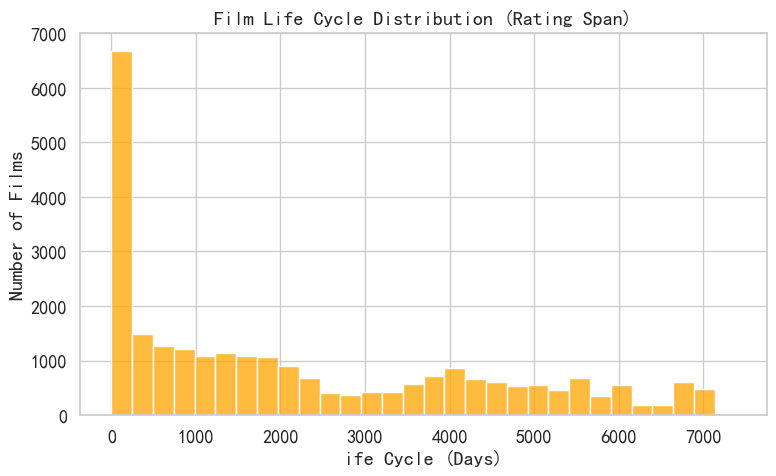

In [14]:
# Curve of Film Life Cycles (Old and New)
movie_life = rating.groupby('movieId')['datetime'].agg(['min', 'max'])
movie_life['lifespan'] = (movie_life['max'] - movie_life['min']).dt.days
final_df = final_df.merge(movie_life['lifespan'], on='movieId', how='left')

plt.figure(figsize=(8, 5))
sns.histplot(final_df['lifespan'].dropna(), bins=30, color='orange')
plt.title('Film Life Cycle Distribution (Rating Span)')
plt.xlabel('ife Cycle (Days)')
plt.ylabel('Number of Films')
plt.tight_layout()
plt.show()

### 📊 Distribution of Film Lifecycle (Rating Span)
> 💡 **Insight:**
> - The majority of films have their lifecycle (the period between the first and last ratings) concentrated within one year after release, and works with a duration exceeding five years are gradually becoming scarce.
> - The lifecycle of film popularity is relatively short, and platforms should enhance the efficiency of new film recommendations.
> - For films with a long lifecycle, it indicates that they have sustained long-tail value, making them suitable for "wake-up operation" or "recommendation of obscure treasures".

## Part 3: User Profile Analysis 

- User rating distribution and rating style (mean × standard deviation)
- User activity analysis: Lifecycle distribution / Weekly active time
- User type preference profile (radar chart)
- User clustering analysis (based on rating behavior or preference dimensions) 

💡 **Highlights**:
- Distinguish between "core loyal users" and "lightweight casual users" in terms of behavioral patterns
- Capture type preferences, which is beneficial for personalized content recommendations
- User group stratification can be utilized for refined operations or differentiated recommendation strategies

C:\Users\cherish\AppData\Local\Temp\ipykernel_25636\3300310150.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

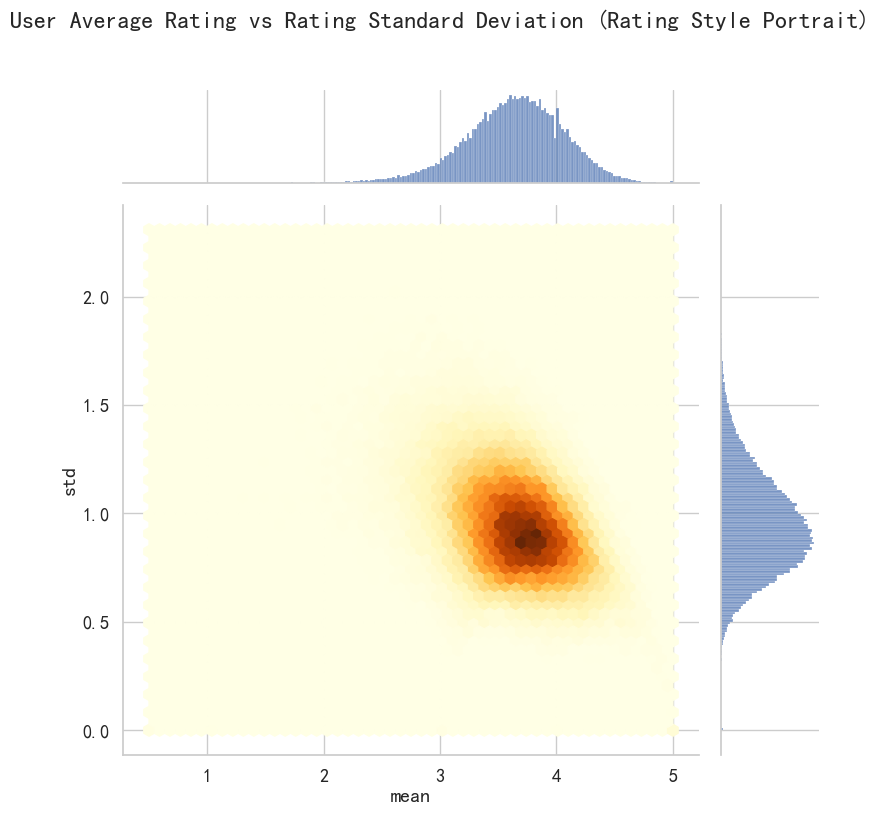

In [15]:
# User Rating Standard Deviation vs Average Rating (Heatmap)
user_score_stats = rating.groupby('userId')['rating'].agg(['mean', 'std'])
user_score_stats = user_score_stats[user_score_stats['std'].notna()]  # Exclude users who rated only one movie

plt.figure(figsize=(8, 6))
sns.jointplot(data=user_score_stats, x='mean', y='std', kind='hex', height=8, cmap='YlOrBr')
plt.suptitle("User Average Rating vs Rating Standard Deviation (Rating Style Portrait)", y=1.02)
plt.tight_layout()
plt.show()

### 📊 **Average User Rating vs. Standard Deviation (Rating Style Profile)**
> 💡 **Insight:**
> - The central area of the image (average rating 3.5-4, standard deviation 0.8-1.0) is where the majority of users are concentrated, indicating that the majority of users have a moderate rating style and relatively few extreme ratings.
> - This graph can be used to label users with style tags (such as tolerant or strict).
> - Personalized recommendations in the future can be based on the style for differentiated model parameter tuning.

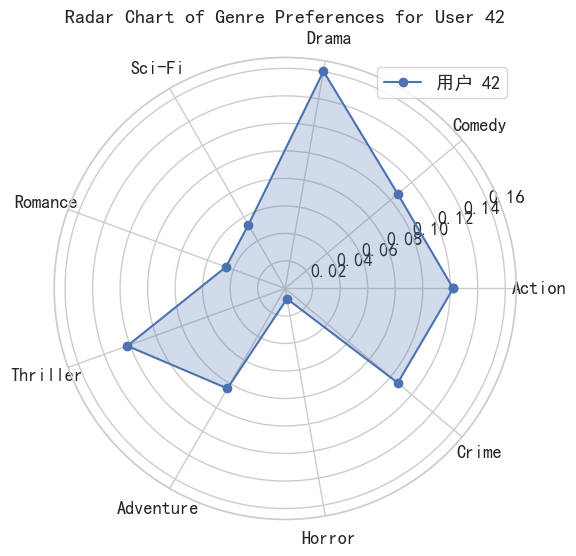

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_user_genre_radar(user_id, rating_df, movie_df):
    
    # Movies rated by this user
    user_movies = rating_df[rating_df['userId'] == user_id][['movieId']]
    user_movies = user_movies.merge(movie_df[['movieId', 'genres_list']], on='movieId', how='left')

    # Expand type, count frequency
    exploded = user_movies.explode('genres_list')
    genre_pref = exploded['genres_list'].value_counts(normalize=True).sort_values(ascending=False)

    # Ensure consistency of dimensions (common types)
    genres = ['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Romance', 'Thriller', 'Adventure', 'Horror', 'Crime']
    values = [genre_pref.get(g, 0) for g in genres]

    angles = np.linspace(0, 2 * np.pi, len(genres), endpoint=False).tolist()
    angles += angles[:1]
    values += values[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, marker='o', label=f'用户 {user_id}')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(genres)
    plt.title(f"Radar Chart of Genre Preferences for User {user_id}")
    plt.legend(loc='upper right')
    plt.show()

# Test
plot_user_genre_radar(42, rating_df=rating, movie_df=final_df)

### 📊 User Type Preference Radar Chart (Single User Portrait)
> 💡 **Insight:**
> - This user has a significant preference for Drama, Thriller, Action, and Crime genres, accounting for the majority of the rated films.
> - There is an extremely low interest in Horror genres, which may warrant a reduction in the exposure of such content in personalized recommendations.
> - By combining the viewing time periods and rating distributions of this user, further user segmentation portraits can be made, providing a basis for precise content recommendations, marketing strategies, membership package combinations, etc.

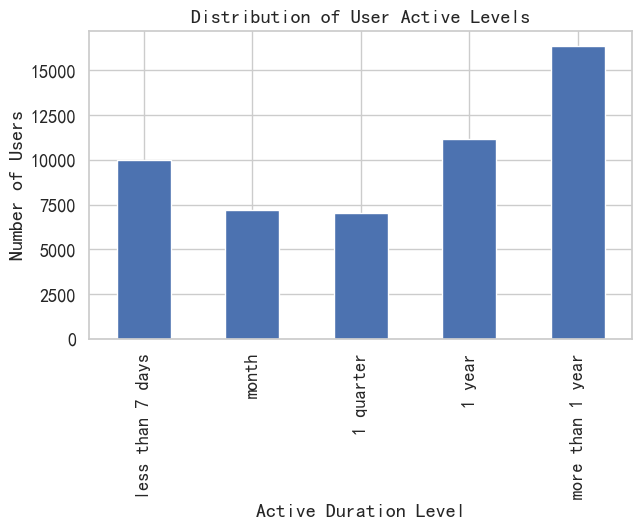

In [17]:
# User Lifecycle (Active Level Stratification)
import pandas as pd
import matplotlib.pyplot as plt

rating['datetime'] = pd.to_datetime(rating['timestamp'], errors='coerce')
user_life = rating.groupby('userId')['datetime'].agg(['min', 'max'])
user_life['days_active'] = (user_life['max'] - user_life['min']).dt.days

user_life['activity_level'] = pd.cut(user_life['days_active'], bins=[0, 7, 30, 90, 365, 10000],
                                     labels=['less than 7 days', 'month', '1 quarter', '1 year', 'more than 1 year'])

plt.figure(figsize=(7, 4))
user_life['activity_level'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of User Active Levels')
plt.xlabel('Active Duration Level')
plt.ylabel('Number of Users')
plt.show()

### 📊 User Lifecycle Distribution Chart (Active Time)
> 💡 **Insight:**
> - Over 60% of users are active within 30 days, indicating a significant "content attraction loss" on the platform.
> - Long-term active users can be regarded as the core assets of the platform.
> - The "long-tail content recommendation" strategy can be combined to enhance retention.

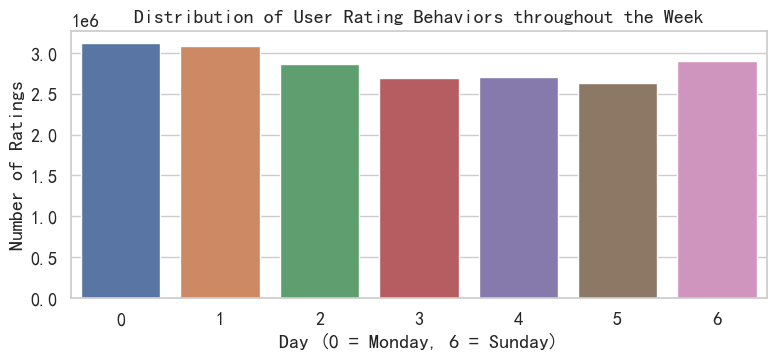

In [18]:
# Holiday / Weekend Active Analysis Chart
rating['datetime'] = pd.to_datetime(rating['timestamp'], errors='coerce')
rating['weekday'] = rating['datetime'].dt.dayofweek

plt.figure(figsize=(8, 4))
sns.countplot(x='weekday', data=rating)
plt.title('Distribution of User Rating Behaviors throughout the Week')
plt.xlabel('Day (0 = Monday, 6 = Sunday)')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.show()

### 📊 Distribution of User Rating Behaviors throughout the Week
> 💡 **Insight:**
> - Rating behaviors are relatively stable during weekdays, but slightly increase on weekends (Saturday and Sunday), especially on Sunday when they are slightly higher. This indicates that users engage in viewing and rating activities on weekends.
> - It is advisable to focus platform operations/recommendation activities on weekends to enhance user activity.
> - Suitable for content operations such as "Weekend Top Films Recommendation" and "Holiday Special Features".

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cherish\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


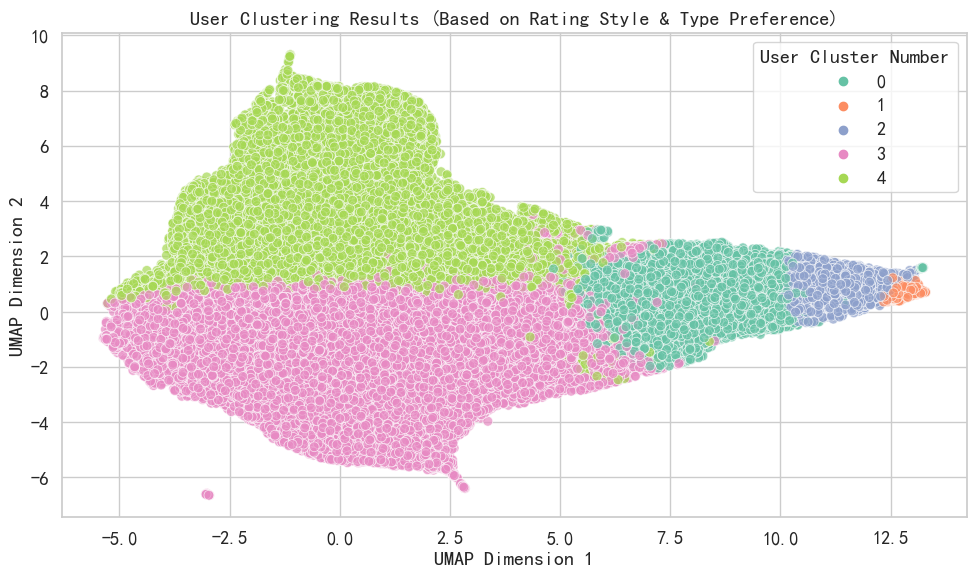

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

user_genre_df = rating.merge(final_df[['movieId', 'genres_list']], on='movieId')
user_genre_long = user_genre_df.explode('genres_list')

# User × Genre: Rating Frequency Matrix
user_genre_matrix = user_genre_long.pivot_table(
    index='userId',
    columns='genres_list',
    values='rating',
    aggfunc='count',
    fill_value=0
)

user_stats = rating.groupby('userId')['rating'].agg(['mean', 'std']).fillna(0)
user_features = user_genre_matrix.join(user_stats)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_features)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
user_features['cluster'] = clusters

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_scaled)

user_features['x'] = embedding[:, 0]
user_features['y'] = embedding[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_features, x='x', y='y', hue='cluster', palette='Set2', s=50, alpha=0.7)
plt.title("User Clustering Results (Based on Rating Style & Type Preference)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="User Cluster Number")
plt.tight_layout()
plt.show()

### 📊 User Clustering Visualization (UMAP + KMeans) 
> 💡 **Insight:**
> - Users naturally form several behavioral groups, such as mainstream audience group / independent film enthusiasts / diverse explorers.
> - Each group has distinct content preferences, and the platform can implement "content configuration based on user groups".
> - It can be used for cold-start user profiling prediction, A/B testing population division, etc.

## Part 4: Content-Based Recommendation System
- Actor popularity, type dummy variables, TF-IDF of tags → Calculate similarity
- Cold-start movie recommendation (combining ratings, tags, types, etc.) 

💡 **Highlights**:
- Construct movie profiles (actor popularity, genre distribution, TF-IDF tags, etc.)
- Calculate similar movies using cosine similarity, providing strong recommendation explanations
- Highly scalable, applicable to scenarios with cold-start users or new film releases scenarios

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Select the feature columns to be used for recommendation
feature_cols = ['avg_actor_rating', 'genre_count', 'budget_log', 'revenue_log', 'roi'] + \
               [col for col in final_df.columns if col.startswith('tag_')] + \
               [col for col in final_df.columns if col in genre_dummies.columns]

# Fill in missing values + Standardize
features = final_df[feature_cols].fillna(0)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Build a similarity matrix
similarity_matrix = cosine_similarity(features_scaled)

In [21]:
# Recommended Function
def recommend_movies_by_title(title, top_n=5):
    idx = final_df[final_df['title'].str.contains(title, case=False, na=False)].index
    if len(idx) == 0:
        print("❌ Not Found.")
        return

    idx = idx[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    print(f"\n🎥 Recommendation Based on <{final_df.loc[idx, 'title']}>：\n")
    for i, (movie_idx, score) in enumerate(sim_scores):
        row = final_df.iloc[movie_idx]
        print(f"{i+1}. {row['title']}  | Similarity: {score:.3f}")

In [22]:
# Test
recommend_movies_by_title('Toy Story', top_n=5)


🎥 Recommendation Based on <Toy Story (1995)>：

1. Emperor's New Groove, The (2000)  | Similarity: 0.975
2. Toy Story 2 (1999)  | Similarity: 0.967
3. Monsters, Inc. (2001)  | Similarity: 0.958
4. Shrek the Third (2007)  | Similarity: 0.949
5. Turbo (2013)  | Similarity: 0.936


<Axes: xlabel='rating_count', ylabel='mean_rating'>

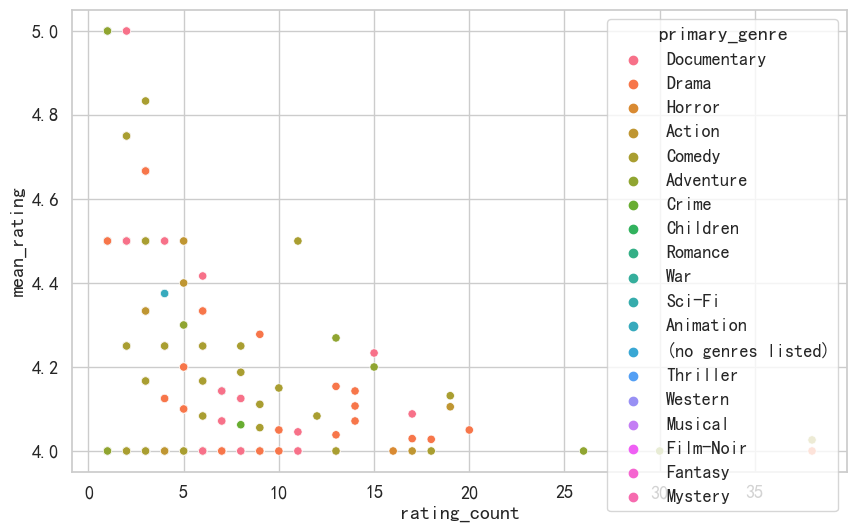

In [64]:
# Content Cold Start Identification Chart
import seaborn as sns
import matplotlib.pyplot as plt

cold_start_plot.loc[:, 'primary_genre'] = cold_start_plot['genres_list'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'
)
sns.scatterplot(
    data=cold_start_plot,
    x='rating_count',
    y='mean_rating',
    hue='primary_genre'
)

### 📊 Cold Start Content Identification (High Score, Low Reviews) 

> 💡 **Insight:**
> - Most of them are documentaries, indie films, foreign-language films, etc., and the platform's exposure rate is insufficient.
> - Potential content can be mined through tag strategies and targeted recommendation algorithms.
> - It is suggested to provide exposure opportunities on the homepage by combining operational resources.

## Part 5: Business Proposals
Business proposals are crucial for any organization aiming to expand its operations or enter new markets. They serve 

Through the systematic exploration from both the content side and the user side in this project, we have put forward the following strategic suggestions to assist the platform in optimizing its content operation and user recommendation strategies: 

---


### 🟡 Suggestions from the Supply Side of Content Production 

- **Supporting high ROI but low-scoring cold-start high-quality content**
By identifying low-popularity but high-scoring niche movies, we provide the platform with the opportunity to "discover treasures and recommend them". For example, in the `Fantasy` category, it has outstanding performance in ROI, but the number of scoring samples is small. It is recommended to set up a strategy of tag traffic support. 

- **A stable director/actor duo with consistent content style**
For instance, directors like Quentin Tarantino and Christopher Nolan not only enjoy high ratings but also have relatively stable ROI fluctuations. They are the stable sources of the platform's "guarantee of content reputation". 

- **Monitor the trend changes of the types that are growing year by year**
The content types such as `Sci-Fi` and `Thriller` have seen an increase in popularity in recent years. It is recommended to increase the proportion of such content in the homepage recommendations and conduct thematic operations based on tag word clouds (such as "Future Fantasy Month"). 

---


### ✅ User-side Strategy Recommendations 

- **Constructing User Profiles + Precise Content Push**
Based on the user rating style (such as: mean and variance of rating preferences) and type preference distribution (radar chart), user groups can be segmented and labeled for hierarchical operation, such as "Literary Youth", "Popcorn Party Fans", and "Fans of Rare Content". 

**Cold Start User Guidance and Recommendation Strategy**
For new users with limited rating behavior, the following recommendations can be sent:
1) Top 10 platforms' reputation; 2) Latest high ROI content; 3) Popular tag-stream recommendations.
These recommendations are provided to guide users to complete the rating task, thereby accelerating the formation of their profiles. 

**Combining Active Periods and Periodic Behaviors with Push Time Strategies**
Users give the highest ratings on Mondays and Sundays. The platform can choose to increase the exposure of the homepage recommendation or push notifications on these two days. 

---


### Suggestion for Optimization of Recommendation System 

- **Design of Multi-Algorithm Hybrid Recommendation System**
- Collaborative Filtering (Item-Based) as the basic module
- Content Similarity (TF-IDF + Type + Actor) for Cold Start Initialization
- Incorporating "High-Rated but Underestimated" Content for "Rare Selection" Recommendation Position 

- Establish a verification process for the effectiveness of the recommendation system
- Set up an A/B testing plan (such as comparing the improved recommendation algorithm with the old version)
- Evaluation indicators: Click-through Rate (CTR), completion rate of playback, changes in subsequent rating scores 

---


### 🧠 Anticipated Earnings of the Platform 

| Strategic Direction                   | Expected Returns                                |
|-----------------------------------------------|------------------------------------------------------------------|
| Cold Start Content Identification and Support | Enhance Platform Content ROI and User Freshness            |
| User Segmentation Portrait              | Precise Push Improves Activity and Conversion Rates          |
| User Segmentation Portrait              | Increase Click-through Rate and Content Matching Satisfaction   |
| A/B Testing Closed Loop                | Achieve Closed Loop from Data Insight to Strategy Implementation |

In conclusion, this project has constructed the portraits and strategies for both the content and users. It has business value orientation, strong implementability, and can directly support the construction and operation optimization of the platform recommendation system.